# Code to generate RDMs for time averaged stimuli for review rebuttal

In [16]:
import numpy as np 

%matplotlib inline 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [17]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
outdir = Path("rebuttal_figs")
outdir.mkdir(parents=True, exist_ok=True)

In [7]:
import torch
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_lower_triangle(matrix, title, xtick_labels=None, ytick_labels=None, xlabel="Location", ylabel="Location", cmap='viridis', vmin=None, vmax=None, symmetric=False, ax=None):
    mask = np.zeros_like(matrix) if symmetric else ~np.tril(np.ones_like(matrix, dtype=bool), k=0)
    masked = np.ma.masked_array(matrix, mask=mask)
    if xtick_labels != None and ytick_labels == None:
        ytick_labels = xtick_labels
    if ytick_labels != None and xtick_labels == None:
        xtick_labels = ytick_labels
        
    if ax is None:
        fig, ax = plt.subplots(figsize=(4, 4))  # Use fig and ax to control layout better
    if vmin is not None and vmax is not None:
        im = ax.imshow(masked, cmap=cmap, vmin=vmin, vmax=vmax)
    else:
        im = ax.imshow(masked, cmap=cmap, vmin=np.nanmin(masked), vmax=np.nanmax(masked))

    # Create colorbar axis with matching height
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(im, cax=cax)  # Use cax here

    ax.set_xticks(np.arange(len(xtick_labels)))
    ax.set_xticklabels(xtick_labels, rotation=90)
    ax.set_yticks(np.arange(len(ytick_labels)))
    ax.set_yticklabels(ytick_labels)

    ax.set_title(title, fontsize=16, pad=20)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    if ax is None:
        sns.despine(ax=ax)
        plt.tight_layout()
        plt.show()
    return ax

# Load pre-computed RDMs

In [13]:
data = pd.read_pickle("data/extended_data_figure_3_cochleagram_rdms.pkl")
azim_rdm_matrix = data['azim_rdm_matrix']
elev_rdm_matrix = data['elev_rdm_matrix']
elevation_labels = data['elevation_labels']
azimuth_labels = data['azimuth_labels']
azimuths =  data['raw_azimuths']


### Plot RDMs with full representation for azimuth conditions

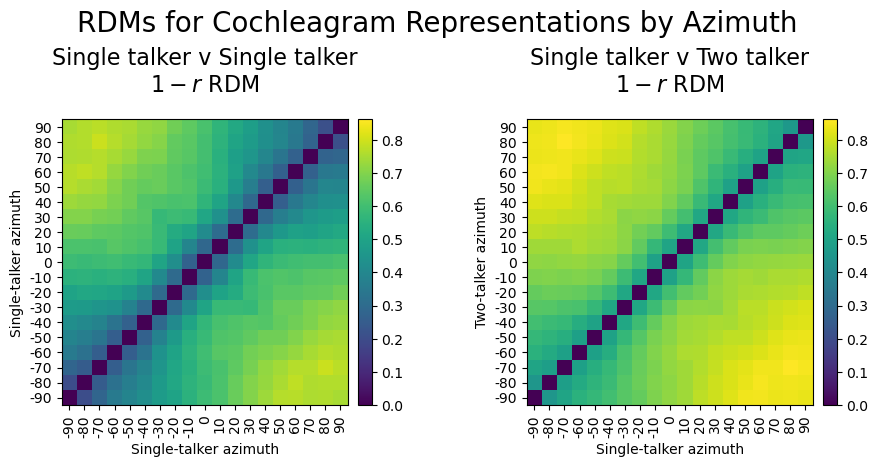

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
xlabel = "Single-talker azimuth"

azim_vmin = np.nanmin(azim_rdm_matrix)
azim_vmax = np.nanmax(azim_rdm_matrix)


for plt_i in range(2):
    ylabel = "Single-talker azimuth" if plt_i == 0 else "Two-talker azimuth"
    panel_title = "Single talker v Single talker" if plt_i == 0 else "Single talker v Two talker"
    # flip columns 
    plot_lower_triangle(azim_rdm_matrix[plt_i,:,:],
                        f"{panel_title}\n$1-r$ RDM", 
                        xtick_labels=azimuth_labels,
                        ytick_labels=azimuth_labels[::-1],
                        xlabel=xlabel, ylabel=ylabel,
                        cmap='viridis', ax=axes[plt_i], vmin=azim_vmin, vmax=azim_vmax, symmetric=True)

plt.suptitle("RDMs for Cochleagram Representations by Azimuth", fontsize=20, y=1)
plt.subplots_adjust(hspace=0.5, wspace=0.5)
# plt.savefig(outdir / "cochleagram_azim_rdm.pdf", bbox_inches='tight', transparent=True)

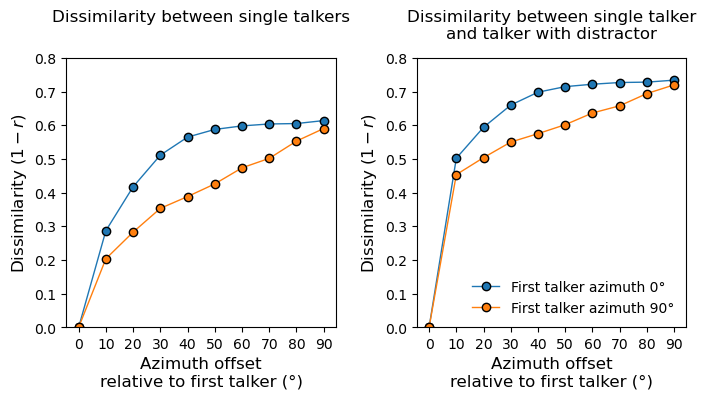

In [14]:
#### Add line plots 

fig, axs = plt.subplots(1,2,figsize=(8,3.5))

fontsize=12

ix_map = {}
for azim in [0, 90]:
    ix_map[azim] = np.where(np.array([loc[0] for loc in azimuths]) == azim)[0][0]

xtick_labels = np.arange(0, 91, 10)
for plt_ix, ax in enumerate(axs):
    for single_src_azim in [0, 90]:
        row_ix = ix_map[single_src_azim]
        zero_ix = ix_map[0]
        ninety_ix = ix_map[90]
        col_ixs = np.arange(zero_ix, ninety_ix+1)
        if single_src_azim == 90:
            col_ixs = np.arange(0, zero_ix+1)
        dissimilarity_values = azim_rdm_matrix[plt_ix, row_ix, col_ixs]
        # if single_src_azim == 90:
        #     dissimilarity_values = np.flip(dissimilarity_values, axis=-1)
        ax.plot(dissimilarity_values,
                 label=f"First talker azimuth {single_src_azim}°",
                 marker='o',
                 markeredgecolor='k',
                 lw=1)
    if plt_ix == 1:
        ax.legend(frameon=False)
    ax.set_title("Dissimilarity between single talkers\n" if plt_ix == 0 else "Dissimilarity between single talker\nand talker with distractor", y=1.04)
    ax.set_xticks(np.arange(len(xtick_labels)))
    ax.set_xticklabels(xtick_labels)
    ax.set_xlabel("Azimuth offset\nrelative to first talker (°)", fontsize=fontsize)
    ax.set_ylabel("Dissimilarity $(1-r)$", fontsize=fontsize)  
    ax.set_ylim(0, 0.8)  


ratio = 1 
## make panels square 
# adjust wspace and hspace
plt.subplots_adjust(wspace=0.3, hspace=0.3)
# plt.savefig(outdir / "compare_azim_rdm_gradients.pdf", bbox_inches='tight', transparent=True)

# Run RDMS with time-averaged activations for elevation

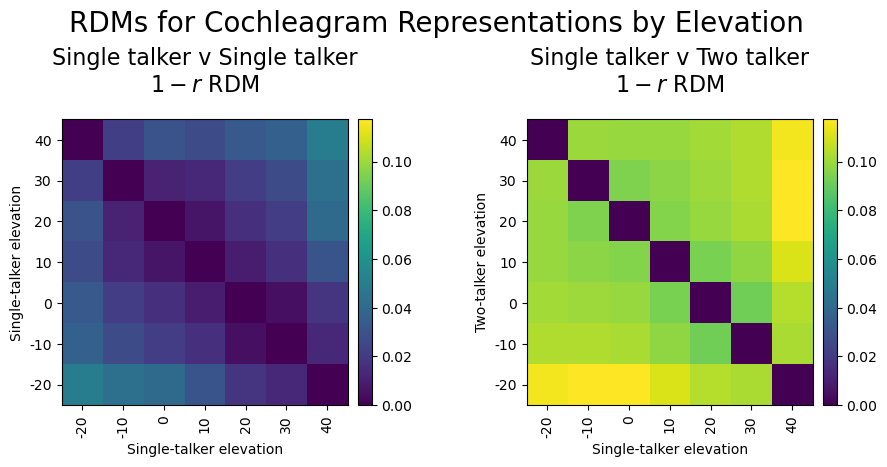

In [15]:

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

xlabel = "Single-talker elevation"

elev_vmin = np.nanmin(elev_rdm_matrix)
elev_vmax = np.nanmax(elev_rdm_matrix)

# flip columns so diagonal goes bottom to top 
elev_rdm_matrix = np.flip(elev_rdm_matrix, axis=1)
for plt_i in range(2):
    ylabel = "Single-talker elevation" if plt_i == 0 else "Two-talker elevation"
    panel_title = "Single talker v Single talker" if plt_i == 0 else "Single talker v Two talker"
    # flip columns 
    plot_lower_triangle(elev_rdm_matrix[plt_i,:,:], f"{panel_title}\n$1-r$ RDM", 
                         xtick_labels=elevation_labels,
                         ytick_labels=elevation_labels[::-1],
                         xlabel=xlabel, ylabel=ylabel,
                        cmap='viridis', ax=axes[plt_i], vmin=elev_vmin, vmax=elev_vmax, symmetric=True)

plt.suptitle("RDMs for Cochleagram Representations by Elevation", fontsize=20, y=1)
# adjust hspace
plt.subplots_adjust(hspace=0.5, wspace=0.5)
# plt.tight_layout()
# plt.savefig(outdir / "cochleagram_elev_rdm.pdf", bbox_inches='tight', transparent=True)